In [40]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns

# Data inspection

In [41]:
rnadata = sc.read_h5ad("./GSM5008737_RNA_finetune_withcelltype.h5ad")
rnadata

AnnData object with n_obs × n_vars = 16177 × 23385
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id'

In [42]:
# Very permissive initial filtering
sc.pp.filter_cells(rnadata, min_genes=100, inplace=True)
sc.pp.filter_genes(rnadata, min_cells=3, inplace=True)
rnadata

AnnData object with n_obs × n_vars = 16177 × 16896
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id', 'n_cells'

In [43]:
rnadata.var["mt"] = rnadata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(rnadata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

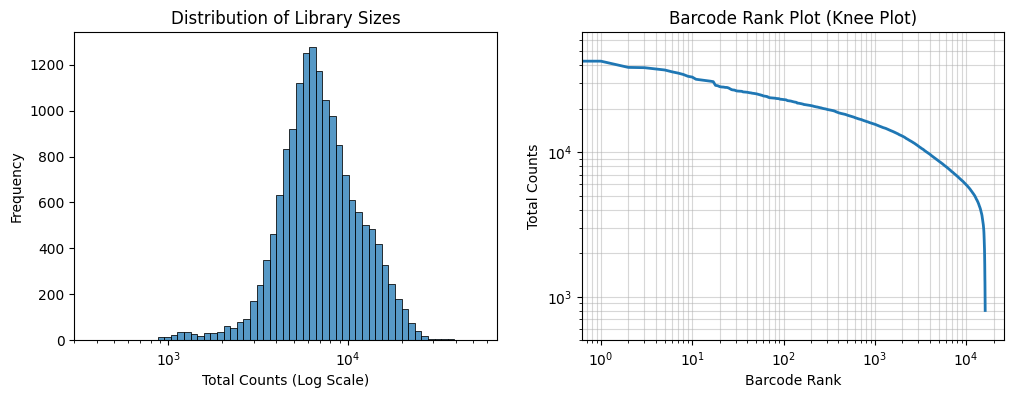

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 1. Histogram (Log Scale)
sns.histplot(rnadata.obs["total_counts"], bins=50, log_scale=True, ax=ax[0])
ax[0].set_title("Distribution of Library Sizes")
ax[0].set_xlabel("Total Counts (Log Scale)")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(300, None)

# 2. Knee Plot (Rank Order)
sorted_counts = np.sort(rnadata.obs["total_counts"])[::-1]  # Sort descending
ranks = np.arange(len(sorted_counts))

ax[1].loglog(ranks, sorted_counts, linewidth=2)
ax[1].set_title("Barcode Rank Plot (Knee Plot)")
ax[1].set_xlabel("Barcode Rank")
ax[1].set_ylabel("Total Counts")
ax[1].grid(True, which="both", ls="-", alpha=0.5)
ax[1].set_ylim(500, None)
plt.show()

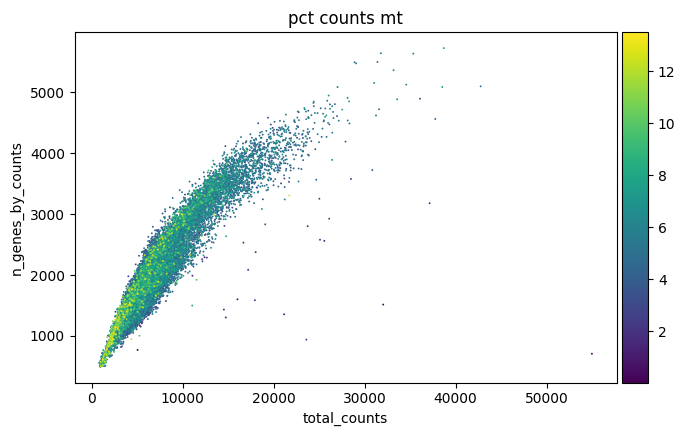

In [45]:
ax = sc.pl.scatter(rnadata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show=False)

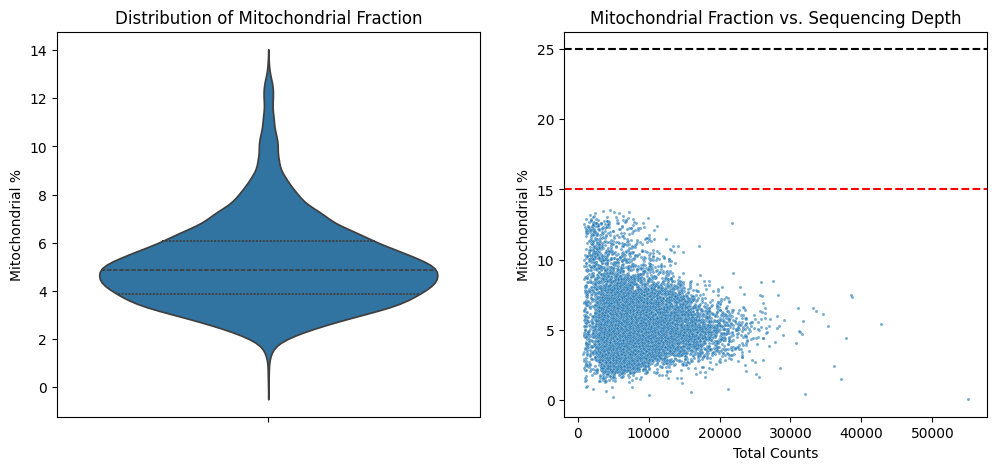

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot A: Violin Plot (Distribution of Mito %)
sns.violinplot(y=rnadata.obs["pct_counts_mt"], ax=ax[0], inner="quartile")
ax[0].set_title("Distribution of Mitochondrial Fraction")
ax[0].set_ylabel("Mitochondrial %")

# Plot B: Scatter Plot (Counts vs Mito %) -> The most important diagnostic
sns.scatterplot(x=rnadata.obs["total_counts"], y=rnadata.obs["pct_counts_mt"], s=5, alpha=0.6, ax=ax[1])
ax[1].set_title("Mitochondrial Fraction vs. Sequencing Depth")
ax[1].set_xlabel("Total Counts")
ax[1].set_ylabel("Mitochondrial %")
# Add common thresholds for visual reference
ax[1].axhline(15, color="r", linestyle="--", label="15% (Strict)")
ax[1].axhline(25, color="k", linestyle="--", label="25% (Permissive)")

plt.show()

Data looks good.. Maybe we could cut off at <= 1500 total counts? Not sure

# Data normalisation

In [47]:
rnadata.X.sum(axis=1)

array([ 8107.,  6642.,  9352., ...,   905.,  4539., 15012.],
      shape=(16177,), dtype=float32)

In [48]:
sc.pp.normalize_total(rnadata, target_sum=1e4)
sc.pp.log1p(rnadata)
rnadata.X

array([[0.       , 0.       , 0.       , ..., 1.7806998, 3.7306345,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.9185165, 4.4638085,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 4.2091007,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 2.4890418,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 3.757926 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.846841 , 3.6963985,
        0.       ]], shape=(16177, 16896), dtype=float32)

In [53]:
protdata = sc.read_h5ad("./GSM5008738_protein_finetune_withcelltype.h5ad")
protdata

AnnData object with n_obs × n_vars = 16177 × 224
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id'

In [54]:
valid_barcodes = rnadata.obs_names

In [66]:
protdata = protdata[valid_barcodes]
protdata

View of AnnData object with n_obs × n_vars = 16177 × 224
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id'

## Choose normalisation method: the one from scTranslator (1) or the default log1p (2)

### Normalisation method (1)

In [67]:
min_per_cell = np.expand_dims(protdata.X.min(axis=1), 1)
max_per_cell = np.expand_dims(protdata.X.max(axis=1), 1)
high = 1
low = 1e-8

In [72]:
protdata.X = (protdata.X - min_per_cell) / (max_per_cell - min_per_cell) * (high - low) + low

/tmp/ipykernel_640544/712914980.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  protdata.X = ((protdata.X - min_per_cell) / (max_per_cell - min_per_cell) * (high - low) + low)


In [74]:
protdata.to_df().to_csv("./proteome_theirs.csv")

### Normalisation method (2)

In [52]:
sc.pp.log1p(protdata)
protdata.X

/opt/venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:412: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


array([[1.0986123, 2.5649493, 4.8121843, ..., 1.3862944, 0.6931472,
        2.1972246],
       [1.7917595, 2.3978953, 3.9512436, ..., 2.3978953, 2.4849067,
        1.7917595],
       [1.3862944, 2.7725887, 4.276666 , ..., 1.9459101, 1.3862944,
        1.0986123],
       ...,
       [2.0794415, 2.3978953, 5.609472 , ..., 1.0986123, 0.       ,
        3.1354942],
       [0.       , 2.3978953, 3.7841897, ..., 1.9459101, 2.7725887,
        2.3025851],
       [2.8332133, 2.8903718, 5.273    , ..., 1.9459101, 2.9957323,
        4.4188404]], shape=(16177, 224), dtype=float32)

In [14]:
protdata.to_df().to_csv("./proteome.csv")

In [15]:
rnadata.obsm["protein_counts"] = protdata.X

In [16]:
rnadata.uns["protein_names"] = protdata.var_names.tolist()
rnadata.uns["protein_names"]

['CD39',
 'CD107a',
 'CD62P',
 'TCR-2',
 'CD30',
 'CD31',
 'CD34',
 'CD35',
 'CD36',
 'CD223',
 'TIGIT',
 'TCR-V-9',
 'CD226',
 'CD178',
 'CD319',
 'CD171',
 'Siglec-8',
 'CD340',
 'VEGFR-3',
 'CD29',
 'CD62E',
 'CD4-2',
 'CD4-1',
 'CD22',
 'CD3-1',
 'CD20',
 'CD27',
 'CD45RB',
 'CD25',
 'CD24',
 'CD146',
 'Galectin-9',
 'CD142',
 'CD141',
 'CD294',
 'CD45RA',
 'CX3CR1',
 'CD56-2',
 'CD56-1',
 'CD45RO',
 'CD303',
 'GP130',
 'CD253',
 'CD357',
 'CD11b-1',
 'CD354',
 'CD11b-2',
 'CLEC12A',
 'CD38-2',
 'CD38-1',
 'Folate',
 'CD209',
 'CD152',
 'CD154',
 'CD155',
 'Cadherin',
 'CD201',
 'CD204',
 'CD205',
 'CD206',
 'CD207',
 'CD1d',
 'CD284',
 'CD1c',
 'Podoplanin',
 'CD1a',
 'CD366',
 'IgD',
 'IgM',
 'CD66a/c/e',
 'CD49d',
 'LOX-1',
 'TIM-4',
 'CD98',
 'CD370',
 'CD49a',
 'CD44-2',
 'C5L2',
 'CD44-1',
 'CD158e1',
 'CD124',
 'CD127',
 'CD126',
 'CD279',
 'CD278',
 'CD123',
 'CD122',
 'CD96',
 'CD274',
 'CD95',
 'CD271',
 'CD270',
 'CD90',
 'CD272',
 'CD16',
 'CD14',
 'CD15',
 'CD13',
 'CD

In [21]:
adata = rnadata.copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 16177 × 16896
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'protein_counts'

In [35]:
del adata.uns
del adata.obsm
del adata.var
del adata.obs

In [39]:
adata.X

array([[0.       , 0.       , 0.       , ..., 1.7806998, 3.7306345,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.9185165, 4.4638085,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 4.2091007,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 2.4890418,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 3.757926 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.846841 , 3.6963985,
        0.       ]], shape=(16177, 16896), dtype=float32)

In [38]:
adata.write_h5ad("./dataset_only_expr.h5ad")

In [22]:
rnadata.write_h5ad("./dataset.h5ad")

In [7]:
import pandas as pd

a = pd.read_csv("./my_init_4gpu_lrx2_prot_embeddings.csv", index_col=0)

In [8]:
import scanpy as sc

In [9]:
qq = sc.read_h5ad("./dataset.h5ad")

In [10]:
qq

AnnData object with n_obs × n_vars = 16177 × 16896
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'protein_names'
    obsm: 'protein_counts'

In [ ]:
sc.pp.highly_variable_genes(qq, n_top_genes=5000, inplace=True)

In [12]:
hvg = qq[:, qq.var["highly_variable"]]

In [ ]:
pd.DataFrame(hvg.X, index=hvg.obs_names, columns=hvg.var.index).to_csv("./rna_10.csv")

In [88]:
sc.pp.highly_variable_genes(qq, n_top_genes=256, inplace=True)

In [89]:
qq[:, qq.var["highly_variable"]]

View of AnnData object with n_obs × n_vars = 16177 × 256
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'protein_names', 'hvg'
    obsm: 'protein_counts'

In [90]:
hvg = qq[:, qq.var["highly_variable"]]

In [93]:
hvg

View of AnnData object with n_obs × n_vars = 16177 × 256
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Gene symbol', 'Gene Expression', 'Entrez_Gene_Id', 'my_Id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'protein_names', 'hvg'
    obsm: 'protein_counts'

In [95]:
hvg.var.index

Index(['C1QA', 'C1QC', 'C1QB', 'STMN1', 'SPOCD1', 'PDZK1IP1', 'TAL1', 'NEXN',
       'LINC01750', 'S100A8',
       ...
       'IGLV2-8', 'IGLC2', 'IGLC3', 'IGLC6', 'IGLC7', 'GNAZ', 'OSBP2', 'PVALB',
       'MAP3K7CL', 'S100B'],
      dtype='object', length=256)

In [96]:
pd.DataFrame(hvg.X, index=hvg.obs_names, columns=hvg.var.index).to_csv("./rna_512.csv")

In [83]:
import pandas as pd

In [57]:
pd.DataFrame(qq.X[:, qq.var["highly_variable"]]).to_csv("./rna.csv")